In [ ]:
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import Callback

from sklearn.datasets import make_circles
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt

import io

from mlxtend.plotting import plot_decision_regions

First let's generate some data. We will be using SKLearn's make_circles to create a dataset that isn't linearly seperable.

In [ ]:
num_points = 300
x, y = make_circles(n_samples=num_points, random_state=144, shuffle=True, factor=0.7, noise=0.01)
y

array([0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1])

Let's visualize the data. As we can see, it consists of two concentric circles where the color of each point represents which class it belongs to.

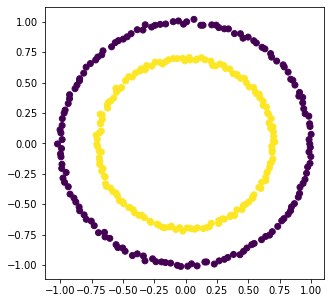

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(x[:, 0], x[:, 1], c=y)
plt.show()

To ensure we aren't overfitting during training, let's split our x and y data into training and testing sets.

To visualize why we want to use a neural network for this problem, let's try to use SKLearn's Logistic Regression to classify the points:

Training Score:  0.5083333333333333
Testing Score:  0.4666666666666667


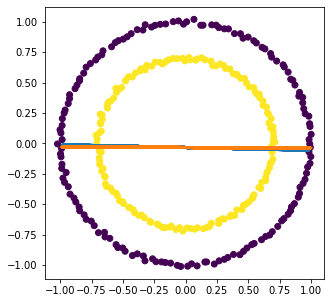

In [ ]:
def perform_logistic_regression(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=144)

    clf = LogisticRegression(random_state=144).fit(x_train, y_train)
    print('Training Score: ', clf.score(x_train, y_train))
    print('Testing Score: ', clf.score(x_test, y_test))

    plt.figure(figsize=(5,5))
    plt.scatter(x[:, 0], x[:, 1], c=y)

    plt.plot(x_test, clf.coef_ * x_test + clf.intercept_, linewidth=3)

    plt.show()

perform_logistic_regression(x, y)

It's apparent that our linear decision boundary won't cut it for this data. Let's try to build a simple neural network that can distinguish between these two classes:

In [ ]:
# tanh(x) = 2 * sigmoid(2x) - 1
def build_model1():
    input_layer = Input(shape=(2))
    x = Dense(8, activation='tanh')(input_layer)
    x = Dense(8, activation='tanh')(x)
    x = Dense(1, activation='sigmoid')(x)
    return Model(input_layer, x)

In [ ]:
def build_model2(): 
  model = Sequential() 
  model.add(Dense(units = 8, input_dim=2, activation='tanh')) 
  model.add(Dense(units = 8, activation='tanh')) 
  model.add(Dense(units = 1, activation='sigmoid')) 
  return model

In [ ]:
model = build_model2()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 8)                 24        
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________


Now we need to declare our optimizer and compile our model with our chosen loss, optimizer, and metrics.

In [ ]:
sgd = SGD(lr=0.05, decay=1e-6, momentum=0.9)
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

Before we train our model, let's use mlxtend to visualize the decision boundary. We can see that it initially cannot distinguish between the two classes.

/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


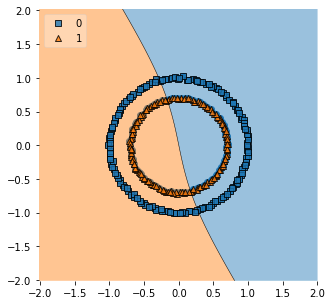

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(x[:, 0], x[:, 1])
plot_decision_regions(x, y, clf=model, legend=2)
plt.show()

For demonstration purposes, we create a callback to recreate the above plot every 10 epochs so we can visualize the progression of our decision boundary as we train our model.

In [ ]:
class ImgCallback(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if epoch % 10 == 0:
            fig = plt.figure(figsize=(5,5))
            plt.scatter(x[:, 0], x[:, 1])
            plot_decision_regions(x, y, clf=model, legend=2)
            plt.show()
            plt.close(fig)

Now let's train our model:

/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


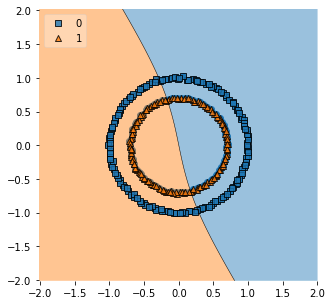

Epoch 1/150
2/2 [==============================] - 0s 52ms/step - loss: 0.7011 - accuracy: 0.5167 - val_loss: 0.7173 - val_accuracy: 0.4167
Epoch 2/150
2/2 [==============================] - 0s 16ms/step - loss: 0.6980 - accuracy: 0.5375 - val_loss: 0.7176 - val_accuracy: 0.4333
Epoch 3/150
2/2 [==============================] - 0s 20ms/step - loss: 0.6930 - accuracy: 0.5500 - val_loss: 0.7169 - val_accuracy: 0.4333
Epoch 4/150
2/2 [==============================] - 0s 17ms/step - loss: 0.6905 - accuracy: 0.6167 - val_loss: 0.7181 - val_accuracy: 0.4500
Epoch 5/150
2/2 [==============================] - 0s 17ms/step - loss: 0.6891 - accuracy: 0.5667 - val_loss: 0.7167 - val_accuracy: 0.4167
Epoch 6/150
2/2 [==============================] - 0s 17ms/step - loss: 0.6885 - accuracy: 0.5208 - val_loss: 0.7134 - val_accuracy: 0.4167
Epoch 7/150
2/2 [==============================] - 0s 17ms/step - loss: 0.6870 - accuracy: 0.5208 - val_loss: 0.7111 - val_accuracy: 0.4167
Epoch 8/150
2/2 [===

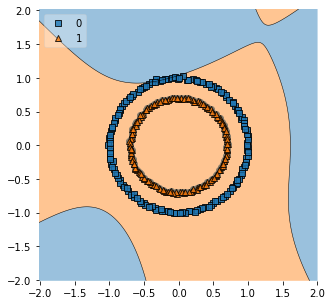

Epoch 11/150
2/2 [==============================] - 0s 17ms/step - loss: 0.6826 - accuracy: 0.5417 - val_loss: 0.6919 - val_accuracy: 0.4833
Epoch 12/150
2/2 [==============================] - 0s 15ms/step - loss: 0.6813 - accuracy: 0.5583 - val_loss: 0.6910 - val_accuracy: 0.4667
Epoch 13/150
2/2 [==============================] - 0s 16ms/step - loss: 0.6797 - accuracy: 0.5542 - val_loss: 0.6903 - val_accuracy: 0.4667
Epoch 14/150
2/2 [==============================] - 0s 16ms/step - loss: 0.6783 - accuracy: 0.5625 - val_loss: 0.6905 - val_accuracy: 0.4333
Epoch 15/150
2/2 [==============================] - 0s 16ms/step - loss: 0.6775 - accuracy: 0.5583 - val_loss: 0.6925 - val_accuracy: 0.4500
Epoch 16/150
2/2 [==============================] - 0s 19ms/step - loss: 0.6756 - accuracy: 0.5375 - val_loss: 0.6927 - val_accuracy: 0.4333
Epoch 17/150
2/2 [==============================] - 0s 16ms/step - loss: 0.6745 - accuracy: 0.5375 - val_loss: 0.6918 - val_accuracy: 0.4500
Epoch 18/150


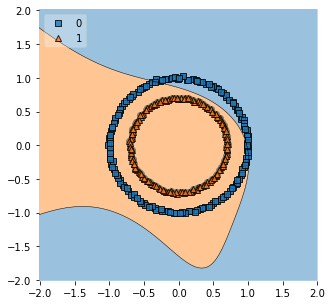

Epoch 21/150
2/2 [==============================] - 0s 19ms/step - loss: 0.6683 - accuracy: 0.6792 - val_loss: 0.6795 - val_accuracy: 0.5500
Epoch 22/150
2/2 [==============================] - 0s 18ms/step - loss: 0.6666 - accuracy: 0.6708 - val_loss: 0.6780 - val_accuracy: 0.5500
Epoch 23/150
2/2 [==============================] - 0s 18ms/step - loss: 0.6650 - accuracy: 0.6542 - val_loss: 0.6777 - val_accuracy: 0.5167
Epoch 24/150
2/2 [==============================] - 0s 17ms/step - loss: 0.6630 - accuracy: 0.6417 - val_loss: 0.6758 - val_accuracy: 0.5333
Epoch 25/150
2/2 [==============================] - 0s 16ms/step - loss: 0.6611 - accuracy: 0.6292 - val_loss: 0.6746 - val_accuracy: 0.5167
Epoch 26/150
2/2 [==============================] - 0s 16ms/step - loss: 0.6594 - accuracy: 0.6292 - val_loss: 0.6729 - val_accuracy: 0.5167
Epoch 27/150
2/2 [==============================] - 0s 17ms/step - loss: 0.6574 - accuracy: 0.6250 - val_loss: 0.6697 - val_accuracy: 0.5167
Epoch 28/150


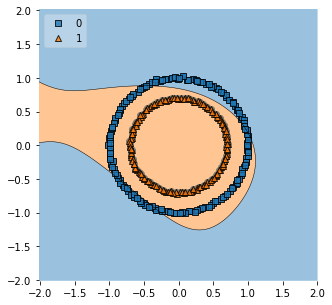

Epoch 31/150
2/2 [==============================] - 0s 19ms/step - loss: 0.6485 - accuracy: 0.7250 - val_loss: 0.6542 - val_accuracy: 0.6500
Epoch 32/150
2/2 [==============================] - 0s 16ms/step - loss: 0.6458 - accuracy: 0.7333 - val_loss: 0.6528 - val_accuracy: 0.6500
Epoch 33/150
2/2 [==============================] - 0s 16ms/step - loss: 0.6430 - accuracy: 0.7333 - val_loss: 0.6513 - val_accuracy: 0.6500
Epoch 34/150
2/2 [==============================] - 0s 16ms/step - loss: 0.6403 - accuracy: 0.7208 - val_loss: 0.6503 - val_accuracy: 0.6333
Epoch 35/150
2/2 [==============================] - 0s 18ms/step - loss: 0.6375 - accuracy: 0.7083 - val_loss: 0.6491 - val_accuracy: 0.6333
Epoch 36/150
2/2 [==============================] - 0s 17ms/step - loss: 0.6340 - accuracy: 0.7083 - val_loss: 0.6451 - val_accuracy: 0.6333
Epoch 37/150
2/2 [==============================] - 0s 17ms/step - loss: 0.6308 - accuracy: 0.7250 - val_loss: 0.6408 - val_accuracy: 0.6667
Epoch 38/150


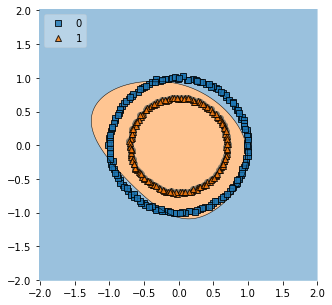

Epoch 41/150
2/2 [==============================] - 0s 20ms/step - loss: 0.6156 - accuracy: 0.7583 - val_loss: 0.6249 - val_accuracy: 0.7333
Epoch 42/150
2/2 [==============================] - 0s 16ms/step - loss: 0.6118 - accuracy: 0.7667 - val_loss: 0.6225 - val_accuracy: 0.7000
Epoch 43/150
2/2 [==============================] - 0s 17ms/step - loss: 0.6067 - accuracy: 0.7667 - val_loss: 0.6178 - val_accuracy: 0.7000
Epoch 44/150
2/2 [==============================] - 0s 16ms/step - loss: 0.6017 - accuracy: 0.7792 - val_loss: 0.6133 - val_accuracy: 0.7167
Epoch 45/150
2/2 [==============================] - 0s 17ms/step - loss: 0.5967 - accuracy: 0.8000 - val_loss: 0.6076 - val_accuracy: 0.7333
Epoch 46/150
2/2 [==============================] - 0s 17ms/step - loss: 0.5914 - accuracy: 0.8333 - val_loss: 0.6023 - val_accuracy: 0.7500
Epoch 47/150
2/2 [==============================] - 0s 18ms/step - loss: 0.5856 - accuracy: 0.8667 - val_loss: 0.5983 - val_accuracy: 0.7500
Epoch 48/150


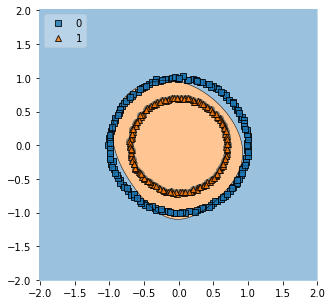

Epoch 51/150
2/2 [==============================] - 0s 20ms/step - loss: 0.5607 - accuracy: 0.8833 - val_loss: 0.5761 - val_accuracy: 0.8333
Epoch 52/150
2/2 [==============================] - 0s 18ms/step - loss: 0.5530 - accuracy: 0.9042 - val_loss: 0.5696 - val_accuracy: 0.8667
Epoch 53/150
2/2 [==============================] - 0s 16ms/step - loss: 0.5466 - accuracy: 0.9375 - val_loss: 0.5619 - val_accuracy: 0.9000
Epoch 54/150
2/2 [==============================] - 0s 18ms/step - loss: 0.5380 - accuracy: 0.9542 - val_loss: 0.5578 - val_accuracy: 0.8833
Epoch 55/150
2/2 [==============================] - 0s 16ms/step - loss: 0.5304 - accuracy: 0.9292 - val_loss: 0.5543 - val_accuracy: 0.8667
Epoch 56/150
2/2 [==============================] - 0s 17ms/step - loss: 0.5216 - accuracy: 0.9042 - val_loss: 0.5465 - val_accuracy: 0.8667
Epoch 57/150
2/2 [==============================] - 0s 17ms/step - loss: 0.5138 - accuracy: 0.9167 - val_loss: 0.5377 - val_accuracy: 0.9000
Epoch 58/150


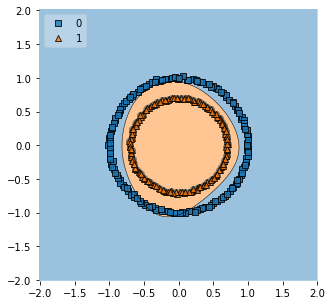

Epoch 61/150
2/2 [==============================] - 0s 21ms/step - loss: 0.4769 - accuracy: 0.9583 - val_loss: 0.5002 - val_accuracy: 0.9167
Epoch 62/150
2/2 [==============================] - 0s 17ms/step - loss: 0.4671 - accuracy: 0.9583 - val_loss: 0.4951 - val_accuracy: 0.8833
Epoch 63/150
2/2 [==============================] - 0s 16ms/step - loss: 0.4573 - accuracy: 0.9542 - val_loss: 0.4883 - val_accuracy: 0.8667
Epoch 64/150
2/2 [==============================] - 0s 16ms/step - loss: 0.4490 - accuracy: 0.9542 - val_loss: 0.4788 - val_accuracy: 0.8667
Epoch 65/150
2/2 [==============================] - 0s 16ms/step - loss: 0.4381 - accuracy: 0.9542 - val_loss: 0.4657 - val_accuracy: 0.9000
Epoch 66/150
2/2 [==============================] - 0s 16ms/step - loss: 0.4277 - accuracy: 0.9583 - val_loss: 0.4544 - val_accuracy: 0.9333
Epoch 67/150
2/2 [==============================] - 0s 17ms/step - loss: 0.4172 - accuracy: 0.9583 - val_loss: 0.4456 - val_accuracy: 0.9333
Epoch 68/150


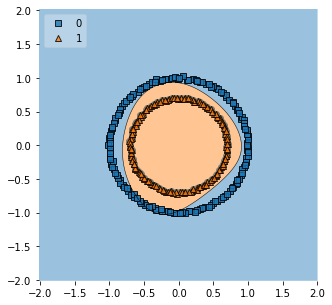

Epoch 71/150
2/2 [==============================] - 0s 19ms/step - loss: 0.3760 - accuracy: 0.9667 - val_loss: 0.4010 - val_accuracy: 0.9500
Epoch 72/150
2/2 [==============================] - 0s 16ms/step - loss: 0.3656 - accuracy: 0.9667 - val_loss: 0.3884 - val_accuracy: 0.9500
Epoch 73/150
2/2 [==============================] - 0s 19ms/step - loss: 0.3547 - accuracy: 0.9708 - val_loss: 0.3797 - val_accuracy: 0.9500
Epoch 74/150
2/2 [==============================] - 0s 16ms/step - loss: 0.3445 - accuracy: 0.9708 - val_loss: 0.3663 - val_accuracy: 0.9667
Epoch 75/150
2/2 [==============================] - 0s 16ms/step - loss: 0.3342 - accuracy: 0.9875 - val_loss: 0.3522 - val_accuracy: 0.9833
Epoch 76/150
2/2 [==============================] - 0s 18ms/step - loss: 0.3234 - accuracy: 0.9917 - val_loss: 0.3395 - val_accuracy: 1.0000
Epoch 77/150
2/2 [==============================] - 0s 16ms/step - loss: 0.3131 - accuracy: 0.9958 - val_loss: 0.3307 - val_accuracy: 1.0000
Epoch 78/150


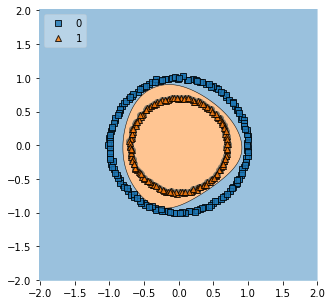

Epoch 81/150
2/2 [==============================] - 0s 19ms/step - loss: 0.2733 - accuracy: 1.0000 - val_loss: 0.2851 - val_accuracy: 1.0000
Epoch 82/150
2/2 [==============================] - 0s 16ms/step - loss: 0.2641 - accuracy: 1.0000 - val_loss: 0.2766 - val_accuracy: 1.0000
Epoch 83/150
2/2 [==============================] - 0s 17ms/step - loss: 0.2546 - accuracy: 1.0000 - val_loss: 0.2659 - val_accuracy: 1.0000
Epoch 84/150
2/2 [==============================] - 0s 17ms/step - loss: 0.2455 - accuracy: 1.0000 - val_loss: 0.2566 - val_accuracy: 1.0000
Epoch 85/150
2/2 [==============================] - 0s 16ms/step - loss: 0.2373 - accuracy: 1.0000 - val_loss: 0.2436 - val_accuracy: 1.0000
Epoch 86/150
2/2 [==============================] - 0s 17ms/step - loss: 0.2283 - accuracy: 1.0000 - val_loss: 0.2356 - val_accuracy: 1.0000
Epoch 87/150
2/2 [==============================] - 0s 18ms/step - loss: 0.2198 - accuracy: 1.0000 - val_loss: 0.2294 - val_accuracy: 1.0000
Epoch 88/150


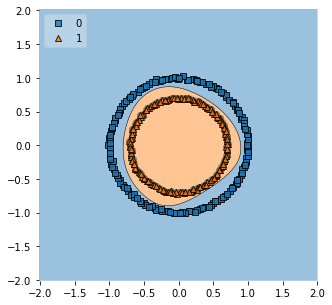

Epoch 91/150
2/2 [==============================] - 0s 19ms/step - loss: 0.1900 - accuracy: 1.0000 - val_loss: 0.1964 - val_accuracy: 1.0000
Epoch 92/150
2/2 [==============================] - 0s 16ms/step - loss: 0.1827 - accuracy: 1.0000 - val_loss: 0.1916 - val_accuracy: 1.0000
Epoch 93/150
2/2 [==============================] - 0s 16ms/step - loss: 0.1758 - accuracy: 1.0000 - val_loss: 0.1801 - val_accuracy: 1.0000
Epoch 94/150
2/2 [==============================] - 0s 16ms/step - loss: 0.1689 - accuracy: 1.0000 - val_loss: 0.1686 - val_accuracy: 1.0000
Epoch 95/150
2/2 [==============================] - 0s 16ms/step - loss: 0.1643 - accuracy: 1.0000 - val_loss: 0.1622 - val_accuracy: 1.0000
Epoch 96/150
2/2 [==============================] - 0s 17ms/step - loss: 0.1569 - accuracy: 1.0000 - val_loss: 0.1633 - val_accuracy: 1.0000
Epoch 97/150
2/2 [==============================] - 0s 18ms/step - loss: 0.1509 - accuracy: 1.0000 - val_loss: 0.1596 - val_accuracy: 1.0000
Epoch 98/150


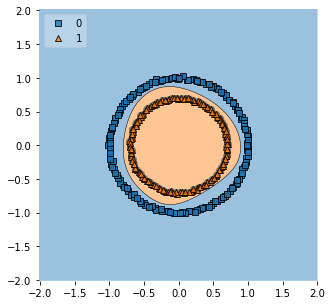

Epoch 101/150
2/2 [==============================] - 0s 20ms/step - loss: 0.1295 - accuracy: 1.0000 - val_loss: 0.1303 - val_accuracy: 1.0000
Epoch 102/150
2/2 [==============================] - 0s 16ms/step - loss: 0.1246 - accuracy: 1.0000 - val_loss: 0.1277 - val_accuracy: 1.0000
Epoch 103/150
2/2 [==============================] - 0s 16ms/step - loss: 0.1202 - accuracy: 1.0000 - val_loss: 0.1236 - val_accuracy: 1.0000
Epoch 104/150
2/2 [==============================] - 0s 17ms/step - loss: 0.1161 - accuracy: 1.0000 - val_loss: 0.1178 - val_accuracy: 1.0000
Epoch 105/150
2/2 [==============================] - 0s 16ms/step - loss: 0.1119 - accuracy: 1.0000 - val_loss: 0.1139 - val_accuracy: 1.0000
Epoch 106/150
2/2 [==============================] - 0s 17ms/step - loss: 0.1078 - accuracy: 1.0000 - val_loss: 0.1084 - val_accuracy: 1.0000
Epoch 107/150
2/2 [==============================] - 0s 15ms/step - loss: 0.1041 - accuracy: 1.0000 - val_loss: 0.1046 - val_accuracy: 1.0000
Epoch 

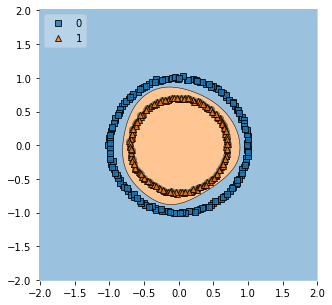

Epoch 111/150
2/2 [==============================] - 0s 20ms/step - loss: 0.0906 - accuracy: 1.0000 - val_loss: 0.0915 - val_accuracy: 1.0000
Epoch 112/150
2/2 [==============================] - 0s 16ms/step - loss: 0.0877 - accuracy: 1.0000 - val_loss: 0.0885 - val_accuracy: 1.0000
Epoch 113/150
2/2 [==============================] - 0s 17ms/step - loss: 0.0848 - accuracy: 1.0000 - val_loss: 0.0855 - val_accuracy: 1.0000
Epoch 114/150
2/2 [==============================] - 0s 17ms/step - loss: 0.0820 - accuracy: 1.0000 - val_loss: 0.0832 - val_accuracy: 1.0000
Epoch 115/150
2/2 [==============================] - 0s 16ms/step - loss: 0.0796 - accuracy: 1.0000 - val_loss: 0.0809 - val_accuracy: 1.0000
Epoch 116/150
2/2 [==============================] - 0s 17ms/step - loss: 0.0769 - accuracy: 1.0000 - val_loss: 0.0777 - val_accuracy: 1.0000
Epoch 117/150
2/2 [==============================] - 0s 18ms/step - loss: 0.0745 - accuracy: 1.0000 - val_loss: 0.0749 - val_accuracy: 1.0000
Epoch 

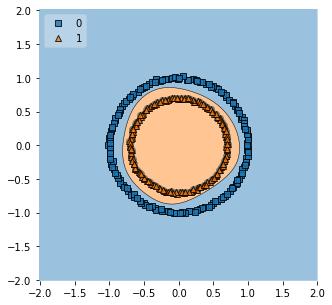

Epoch 121/150
2/2 [==============================] - 0s 20ms/step - loss: 0.0661 - accuracy: 1.0000 - val_loss: 0.0664 - val_accuracy: 1.0000
Epoch 122/150
2/2 [==============================] - 0s 17ms/step - loss: 0.0642 - accuracy: 1.0000 - val_loss: 0.0648 - val_accuracy: 1.0000
Epoch 123/150
2/2 [==============================] - 0s 17ms/step - loss: 0.0623 - accuracy: 1.0000 - val_loss: 0.0637 - val_accuracy: 1.0000
Epoch 124/150
2/2 [==============================] - 0s 16ms/step - loss: 0.0607 - accuracy: 1.0000 - val_loss: 0.0620 - val_accuracy: 1.0000
Epoch 125/150
2/2 [==============================] - 0s 17ms/step - loss: 0.0589 - accuracy: 1.0000 - val_loss: 0.0598 - val_accuracy: 1.0000
Epoch 126/150
2/2 [==============================] - 0s 20ms/step - loss: 0.0573 - accuracy: 1.0000 - val_loss: 0.0575 - val_accuracy: 1.0000
Epoch 127/150
2/2 [==============================] - 0s 17ms/step - loss: 0.0558 - accuracy: 1.0000 - val_loss: 0.0555 - val_accuracy: 1.0000
Epoch 

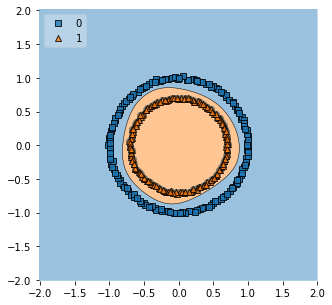

Epoch 131/150
2/2 [==============================] - 0s 22ms/step - loss: 0.0504 - accuracy: 1.0000 - val_loss: 0.0517 - val_accuracy: 1.0000
Epoch 132/150
2/2 [==============================] - 0s 17ms/step - loss: 0.0491 - accuracy: 1.0000 - val_loss: 0.0500 - val_accuracy: 1.0000
Epoch 133/150
2/2 [==============================] - 0s 20ms/step - loss: 0.0479 - accuracy: 1.0000 - val_loss: 0.0481 - val_accuracy: 1.0000
Epoch 134/150
2/2 [==============================] - 0s 17ms/step - loss: 0.0468 - accuracy: 1.0000 - val_loss: 0.0466 - val_accuracy: 1.0000
Epoch 135/150
2/2 [==============================] - 0s 18ms/step - loss: 0.0457 - accuracy: 1.0000 - val_loss: 0.0456 - val_accuracy: 1.0000
Epoch 136/150
2/2 [==============================] - 0s 18ms/step - loss: 0.0446 - accuracy: 1.0000 - val_loss: 0.0449 - val_accuracy: 1.0000
Epoch 137/150
2/2 [==============================] - 0s 17ms/step - loss: 0.0436 - accuracy: 1.0000 - val_loss: 0.0445 - val_accuracy: 1.0000
Epoch 

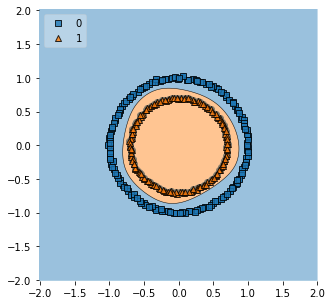

Epoch 141/150
2/2 [==============================] - 0s 20ms/step - loss: 0.0400 - accuracy: 1.0000 - val_loss: 0.0395 - val_accuracy: 1.0000
Epoch 142/150
2/2 [==============================] - 0s 19ms/step - loss: 0.0390 - accuracy: 1.0000 - val_loss: 0.0390 - val_accuracy: 1.0000
Epoch 143/150
2/2 [==============================] - 0s 17ms/step - loss: 0.0381 - accuracy: 1.0000 - val_loss: 0.0389 - val_accuracy: 1.0000
Epoch 144/150
2/2 [==============================] - 0s 16ms/step - loss: 0.0374 - accuracy: 1.0000 - val_loss: 0.0386 - val_accuracy: 1.0000
Epoch 145/150
2/2 [==============================] - 0s 23ms/step - loss: 0.0367 - accuracy: 1.0000 - val_loss: 0.0374 - val_accuracy: 1.0000
Epoch 146/150
2/2 [==============================] - 0s 22ms/step - loss: 0.0359 - accuracy: 1.0000 - val_loss: 0.0361 - val_accuracy: 1.0000
Epoch 147/150
2/2 [==============================] - 0s 19ms/step - loss: 0.0351 - accuracy: 1.0000 - val_loss: 0.0351 - val_accuracy: 1.0000
Epoch 

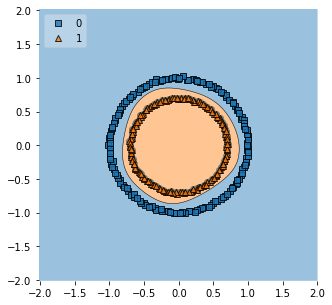

In [ ]:
# Create callback object
img_callback = ImgCallback()

# Perform model fitting
history = model.fit(x,
                    y, 
                    epochs=150, 
                    batch_size=128, 
                    validation_split=0.2,
                    callbacks=[img_callback])

# Printing our last decision boundary plot
fig = plt.figure(figsize=(5,5))
plt.scatter(x[:, 0], x[:, 1])
plot_decision_regions(x, y, clf=model, legend=2)
plt.show()
plt.close(fig)

Here we define some functions to plot the history data that the fit() function returns:

In [ ]:
def plot_losses(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

def plot_accuracies(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

We can see that our train and test losses decrease with a similar trend and ending at a similar value. This is a good indication that we are not overfitting on our testing data.

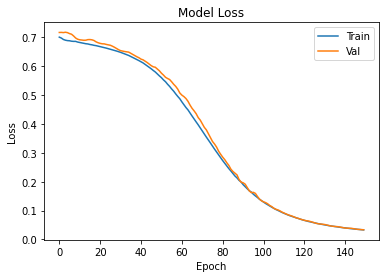

In [ ]:
plot_losses(history)

We can also observe model performance via accuracy. Accuracy is simply defined as the number of datapoints classified correctly over the total number of datapoints.

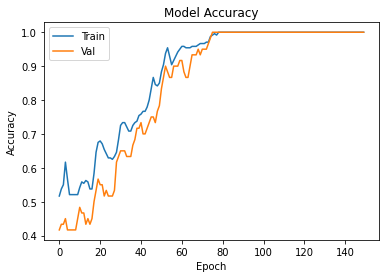

In [ ]:
plot_accuracies(history)